# SYDE556/750 Assignment 3: Connecting Neurons

- Due Date: March 6rd
- Total marks: 10 (10% of final grade)
- Late penalty: 1 mark per day

- It is recommended that you use a language with a matrix library and graphing capabilities.  Two main suggestions are Python and MATLAB.
- *Do not use or refer to any code from Nengo*

## 1) Decoding from a population

As you did in previous assignments, make a population of 20 LIF neurons representing a 1-dimensional value, and compute a decoder for them.  For parameters, $\tau_{ref}$=0.002s, $\tau_{RC}$=0.02s, the maximum firing rates are chosen randomly from a uniform distribution between 100 and 200Hz (at the max radius), and the x-intercepts are chosen randomly from a uniform distribution between -2 and 2.  Remember that the $\alpha$ and $J^{bias}$ terms are computed based on these x-intercepts and maximum firing rates.

It is generally easiest to compute decoders using the original method from Assignment 1, where we use the rate-mode approximation for the neurons to generate the $A$ matrix, then find $\Gamma=A^T A + \sigma^2 I$.  You can use this approach to find decoders, and these decoders should work even when you simulate the neurons in terms of spikes (in question 2 on).  The only difference will be that they will need to be scaled by ``dt``, your simulation time step.

Use this same method for computing decoders for this whole assignment.

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[0.5 marks] Plot the tuning curves (firing rate of each neuron for different $x$ values between -2 and 2)</li>
<li> [0.5 marks] Compute the decoders and plot $(x-\hat{x})$.  When computing decoders, take into account noise ($\sigma$=0.1 times 200Hz).  When computing $\hat{x}$, add random gaussian noise with $\sigma$=0.1 times 200Hz to the activity. Report the Root Mean-Squared Error (RMSE).</li>
</ol>

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [13]:
#Generates Rectified Linear Neuron
def LIF(x,xRange,gain,bias,e,tau_rc=0.02,tau_ref=0.002):   #Recitified linear neuron
    
    J=gain*x*e+bias
    a=np.zeros(J.size)
    for i in range(J.size):
        a[i]=1/(tau_ref-tau_rc*math.log(1-1/J[i])) if (J[i]>1) else 0
    return a  

# Report the Root Mean Squared Error value
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

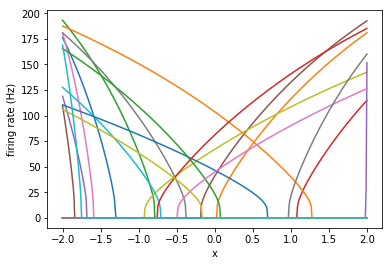

In [14]:
#==================================
#1.a) Plotting tuning curves
#==================================

N=20
tau_rc=0.02
tau_ref=0.002

dx=0.01
x_range=[-2,2]
S=int((x_range[1]-x_range[0])/dx)


x = np.linspace(x_range[0],x_range[1],S)
A=np.zeros((N,S))

xIntercept=np.array([random.uniform(-2,2) for i in range(N)])
frMax=np.array([random.uniform(100,200) for i in range(N)])

gain=np.zeros(N)
bias=np.zeros(N)
e=np.zeros(N)

for i in range(N):
    e[i]=random.choice([-1,1])
    tau_rc=0.02
    tau_ref=0.002
    gain[i]=(1/(x_range[1]-xIntercept[i]))*(1/(1-np.e**((frMax[i]*tau_ref-1)/(frMax[i]*tau_rc))))
    bias[i]=-xIntercept[i]*gain[i]
    A[i]=LIF(x,x_range,gain=gain[i],bias=bias[i],e=e[i])
    plt.plot(x,A[i])
    plt.xlabel('x')
    plt.ylabel('firing rate (Hz)')


Decoder Matrix:  [-1.09236308e-03  2.34901195e-03 -1.58878212e-03  1.39334215e-03
 -1.17817333e-04  2.13985607e-03 -3.20906145e-04 -1.66384744e-03
  1.11409373e-03 -9.65380140e-04 -1.83833089e-03 -2.42799873e-03
 -1.29032597e-03  1.55611697e-03  2.73098891e-04 -6.21084315e-05
  1.33667543e-03  1.82049832e-03 -9.53110596e-04 -1.09559749e-04]


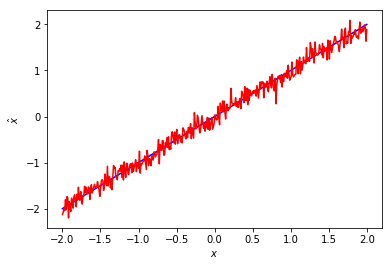

RMSE:  0.13258408606933936


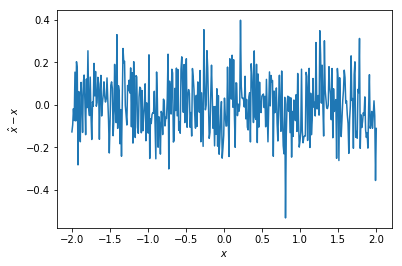

In [15]:
#=========================================
#1.b) Computing decoders/decoding values/error
#=========================================

sigma=0.1*200
A_noisy=A+np.random.normal(scale=sigma,size=A.shape)

Gamma=np.dot(A,A.T)*dx+sigma**2*np.identity(N)
Upsilon=np.dot(A,x)*dx
d_noisy=np.dot(np.linalg.inv(Gamma),Upsilon)
print('Decoder Matrix: ',d_noisy)

xhat=np.dot(A_noisy.T,d_noisy)

plt.show()
plt.plot(x,x,'b')       #plot the line y=x
plt.plot(x,xhat,'r')   #plot the x vs. x_hat
plt.xlabel('$x$')
plt.ylabel('$\hat{x}$')

plt.show()
plt.plot(x,xhat-x)  #plot for x_hat-x
plt.xlabel('$x$')
plt.ylabel('$\hat{x}-x$')

rmse_val = rmse(x,xhat)
print('RMSE: ' ,rmse_val)

## 2) Decoding from two spiking neurons

Choose a neuron from part 1 that has a firing rate of somewhere between 20-50Hz for $x$=0.  Using that neuron's $\alpha$ and $J^{bias}$ value, construct two neurons: both with the same $\alpha$ and $J^{bias}$, but one with $e$=+1 and the other with $e$=-1.  With the function from the last assignment, generate a random input $x(t)$ that is 1 second long, with rms=1, dt=0.001, and an upper limit of 5Hz.  Feed that signal into the two neurons and generate spikes.  Decode the spikes back into $\hat{x}(t)$ using a post-synaptic current filter $h(t)$ with a time constant of $\tau$=0.005.

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[0.5 marks] Plot the post-synaptic current $h(t)=e^{-t/\tau}/ \int e^{-t'/\tau} dt'$</li>
<li>[0.5 marks] Plot the original signal $x(t)$, the spikes, and the decoded $\hat{x}(t)$ all on the same graph</li>
<li>[0.5 marks] Compute the RMSE of the decoding</li>
</ol>

In [16]:
def PSC_Filter(t,dt,n,tau):
    h = t**n * np.exp(-t/tau)
    h[np.where(t<0)]=0.0
    Area=sum(h)*dt
    h=h/Area
    return h

(0, 0.2)

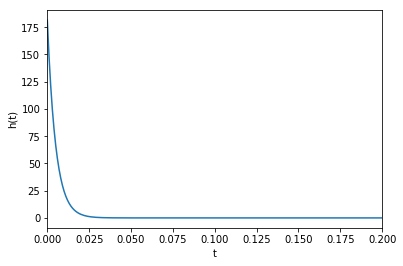

In [17]:
#===========================================
#2.a) plotting post synaptic current as a filter
#===========================================
T=1
dt=0.001
t=np.linspace(0,T,int(T/dt))

n=0
tau=0.005

h=PSC_Filter(t,dt,n,tau)
plt.show()
plt.plot(t, h)
plt.xlabel('t')
plt.ylabel('h(t)')
plt.xlim([0,0.2])

(0, 200)

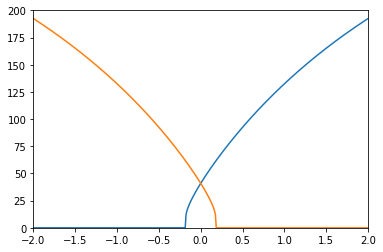

In [18]:
#===============================
#Tuning Curve of Neurons#
#================================
aOn=np.zeros(S)
aOff=np.zeros(S)

for i in range(N):
    if e[i]==1 and 50>A[i,int(S/2)]>20: 
        aOn=A[i]
       
        alpha=gain[i]
        Jbias=bias[i]
                
        aOff=LIF(x,x_range,gain=gain[i],bias=bias[i],e=-1)
        
        break
#Just in case that no neuron exists with fr=[20 50] at x=0 
if aOn.max()==0:
    print("no neurons from the previous population has been found")
    fr_0=random.uniform(20,50)
    fr_2=random.uniform(100,200)
    
    Jbias=1/(1-np.e**((tau_ref*fr_0-1)/(tau_rc*fr_0)))
    alpha=(1/(1-np.e**((tau_ref*fr_2-1)/(tau_rc*fr_2)))-Jbias)/x_range[1]
    
    aOn=LIF(x,x_range,gain=alpha,bias=Jbias,e=1) #e is equal to 1
    aOff=LIF(x,x_range,gain=alpha,bias=Jbias,e=-1) #e is equal to -1

    
plt.figure()
plt.plot(x,aOn)
plt.plot(x,aOff)
plt.xlim(-2,2)
plt.ylim(0,200)  

In [19]:
def calcRMS(signal):
    return np.sqrt(np.sum(signal**2)/float(len(signal)))

In [20]:
#Generating gaussian white noise
def generate_signal(T,dt,rms,limit,seed=None):
    if (seed):
        np.random.seed(seed)
    
    S=int(T/dt)  
    freq = np.arange(S)/T - (S)/(2*T)

    mu, sigma=0,1  
   
    X=np.zeros(S, dtype=np.complex)
    x=np.zeros(S)
    
    for i in range(S//2+1,S-1): #I changed this line from previous code
        if freq[i]<=limit:
            X[i]=complex(np.random.normal(mu,sigma),np.random.normal(mu,sigma))
            X[-i]=np.conjugate(X[i])
    
    #Normalizing the frequency response by implimenting RMS
    x=np.fft.ifft(np.fft.ifftshift(X)).real #go to time domain
    x=x*rms/calcRMS(x) # normalizing the signal in time domain
    
    return x,X

In [21]:
#Two Spiking Neurons
class twoSpikingNeurons():

    def __init__(self,x,xRange, dt, Alpha, Jbias, tau_rc=0.02, tau_ref=0.002):
        
        self.x=x
        self.xRange=xRange
        self.dt=dt
        self.alpha=alpha
        self.Jbias=Jbias
        self.tau_rc=tau_rc
        self.tau_ref=tau_ref
        
    def spikesTrain(self):    
        J=np.zeros([2,self.x.size]) # J related to two spiking neurons
        V=np.zeros([2,self.x.size])
        self.spikes=np.zeros([2,self.x.size])

        J[0]=self.alpha*self.x+self.Jbias   #On Neuron Current
        J[1]=-self.alpha*self.x+self.Jbias  #Off Neuron Current


        for n in range(2):
            i=1 
            while i<self.x.size:
                V[n,i]=V[n,i-1]+1/tau_rc*(J[n,i-1]-V[n,i-1])*dt
                if V[n,i]<0:
                    V[n,i]=0
                if V[n,i]>1:
                    V[n,i]=0
                    self.spikes[n,i]=1 
                    i+=int(tau_ref/dt)
                else:     
                    i+=1
        
        return self.spikes

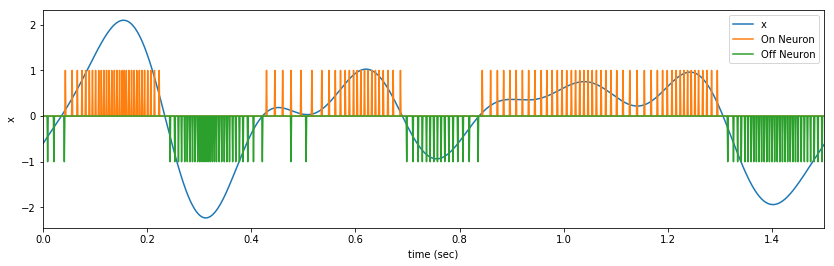

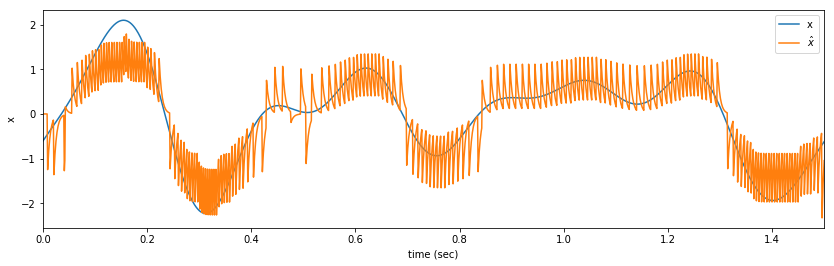

In [22]:
#===================================
#2.b) plotting x(t)/Spikes/x_hat(t)
#===================================
T=1.5
dt=0.001
rms=1
limit=5
t=np.linspace(0,T,int(T/dt))
x_range=[-2,2]

[x,X]=generate_signal(T,dt,rms,limit,seed=15)

fspikesOn=np.zeros(t.size)
fspikesOff=np.zeros(t.size)

neurons=twoSpikingNeurons(x.copy(),x_range, dt, alpha, Jbias, tau_rc=0.02, tau_ref=0.002)
spikes=neurons.spikesTrain()

for i in range(t.size):
    t_prime=t-i*dt
    h=PSC_Filter(t_prime,dt,n,tau)
       
    fspikesOn+=spikes[0,i]*h
    fspikesOff+=spikes[1,i]*h

A=np.array([fspikesOn,fspikesOff]).T

gamma=np.dot(A.T,A)*dx
upsilon=np.dot(A.T,x)*dx
d = np.dot(np.linalg.inv(gamma),upsilon)

xhat = np.dot(A, d)

plt.figure(figsize=(14, 4))
plt.plot(t,x,label='x')
plt.plot(t,neurons.spikes[0],label="On Neuron")
plt.plot(t,-neurons.spikes[1],label="Off Neuron")
plt.xlabel('time (sec)')
plt.ylabel('x')
plt.xlim(0,1.5)
plt.legend()

plt.figure(figsize=(14, 4))
plt.plot(t,x,label='x')
plt.plot(t, xhat, label='$\hat{x}$') 
plt.xlabel('time (sec)')
plt.ylabel('x')
plt.xlim(0,1.5)
plt.legend()

In [23]:
# Report the Root Mean Squared Error value
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [24]:
#=========================================
#2.c) Calculating RMS error between x & xhat
#=========================================
print("RMSE=",rmse(x,xhat))

RMSE= 0.4528505316167801


## 3) Decoding from many neurons

Repeat question 2, but with more neurons.  Instead of picking particular neurons, randomly generate them with x-intercepts uniformly distributed between -2 and 2 and with maximum firing rates between 100 and 200 Hz.  Randomly choose encoder values to be either -1 or +1.

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[2 marks] Plot Root Mean-Squared Error as the number of neurons increases, on a log plot.  Try 8 neurons, 16 neurons, 32, 64, 128, up to 256.  For the RMSE for a particular number of neurons, average over at least 5 randomly generated groups of neurons.  For each group of neurons, randomly generate the signal $x(t)$.  Use the same parameters as in question 2. Note: the RMSE should go down as the number of neurons increases</li>
</ol>

In [25]:
class spikingNeurons():
    
    def __init__(self,N,dimension,x,xRange, dt, Alpha, Jbias,encoder, tau_rc=0.02, tau_ref=0.002):
        
        self.N=N
        self.dimension=dimension
        self.x=x
        self.xRange=xRange
        self.dt=dt
        self.Alpha=Alpha
        self.Jbias=Jbias
        self.encoder=encoder
        self.tau_rc=tau_rc
        self.tau_ref=tau_ref
        
    def spikesTrain(self):    
        nS=int(self.x.size/self.dimension)
        J=np.zeros([self.N,nS]) 
        V=np.zeros([self.N,nS])
        self.spikes=np.zeros([self.N,nS])
     
        for i in range(self.N):
            if self.dimension==1: J[i]=self.Alpha[i]*self.x*self.encoder[i]+self.Jbias[i]   
            else: 
                J[i]=self.Alpha[i]*np.dot(self.x,self.encoder[i])+self.Jbias[i]
               
        
        for n in range(self.N):
            i=1 
            while i<nS:
                V[n,i]=V[n,i-1]+1/self.tau_rc*(J[n,i-1]-V[n,i-1])*self.dt
                if V[n,i]<0:
                    V[n,i]=0
                if V[n,i]>1:
                    V[n,i]=0
                    self.spikes[n,i]=1 
                    i+=int(self.tau_ref/self.dt)
                else:     
                    i+=1
        return self.spikes

In [26]:
#General Function for calculating Alpha and gain Parameters for LIF Neurons

def CalcAlphaJbias(N,tau_rc=0.02,tau_ref=0.002,frMaxRange=[100,200],xRange=[-1,1],xInterceptRange=[-1,1]):  
                
    xIntercept=np.array([random.uniform(xInterceptRange[0],xInterceptRange[1]) for i in range(N)])
    frMax=np.array([random.uniform(frMaxRange[0],frMaxRange[1]) for i in range(N)])

    gain=np.zeros(N)
    bias=np.zeros(N)

    
    for i in range(N):
        gain[i]=(1/(xRange[1]-xIntercept[i]))*(1/(1-np.e**((frMax[i]*tau_ref-1)/(frMax[i]*tau_rc))))
        bias[i]=-xIntercept[i]*gain[i]
         
    return gain,bias     

In [27]:
def CalcEncoder(N,dimension=1):
    
    encoder=np.ones([N,dimension])
    
    for i in range(N):
        if dimension==1: encoder[i]=random.choice([-1,1])
        if dimension==2: 
            theta=random.uniform(0,2*np.pi)
            encoder[i]=[np.cos(theta),np.sin(theta)] 
    
    return encoder

In [28]:
#Method used for this question only 

def DecodingEnsemble(N,N_run=5,dx=0.001,T=1,dt=0.001,rms=1,limit=5,seed=None):
    
    x_range=[-2,2]
    rmse_N=np.zeros(N_run)
    
    [x,X]=generate_signal(T,dt,rms,limit,seed)
    
    A=np.zeros([N,t.size])
    fSpikes=np.zeros([N,t.size])
    
    for i in range(N_run):
        dimension=1
        Alpha,Jbias=CalcAlphaJbias(N,xRange=[-2,2],xInterceptRange=[-2,2])
        encoder=CalcEncoder(dimension=1,N=N)   
       
        neurons=spikingNeurons(N,dimension,x.copy(),x_range, dt, Alpha, Jbias,encoder, tau_rc=0.02, tau_ref=0.002)
        spikes=neurons.spikesTrain()
        
        for j in range(N): 
            for k in range(t.size):
                t_prime=t-k*dt
                h=PSC_Filter(t_prime,dt=0.001,n=0,tau=0.005)
       
                fSpikes[j]+=spikes[j,k]*h
        
        A=fSpikes
        
        Gamma=np.dot(A,A.T)*dx
        Upsilon=np.dot(A,x)*dx
        d=np.dot(np.linalg.pinv(Gamma),Upsilon) 
        
        xhat=np.dot(A.T,d)
        
        rmse_N[i]=rmse(x,xhat)

    rmse_average=np.sum(rmse_N)/N_run
    
    plt.figure(figsize=(14,3))
    plt.title(f"Number of neurons={N}")
    plt.plot(t,x,label='x')
    plt.plot(t, xhat, label='$\hat{x}$') 
    plt.xlabel('time (sec)')
    plt.ylabel('$x$ & $\hat{x}$')
    plt.xlim(0,1)
    plt.legend()
    
    return rmse_average

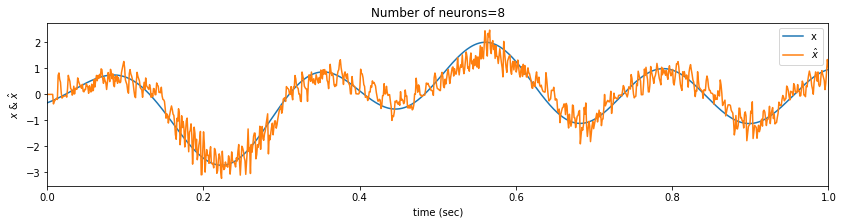

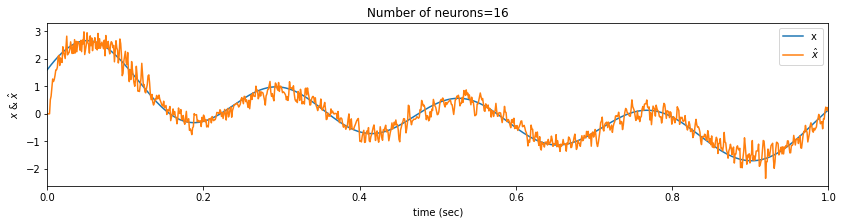

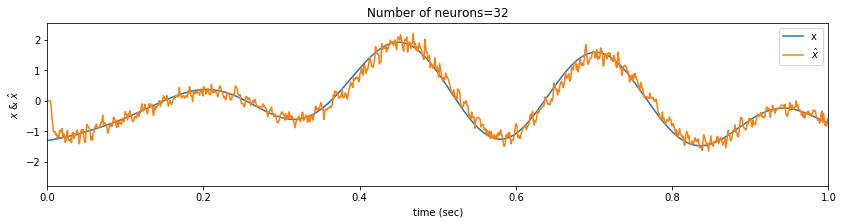

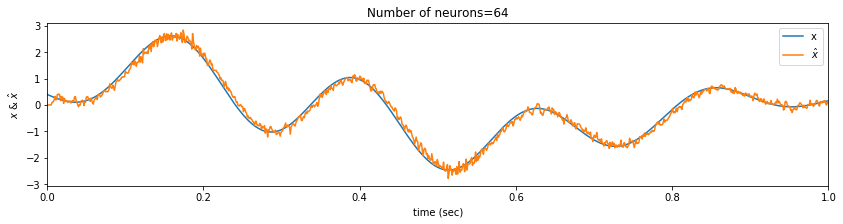

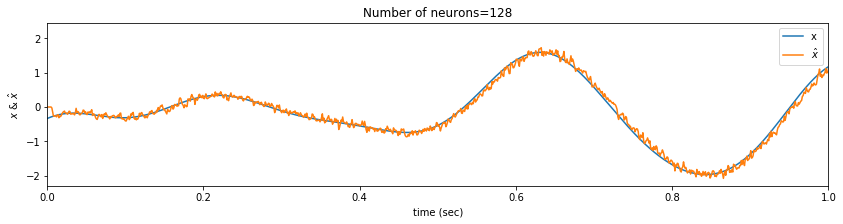

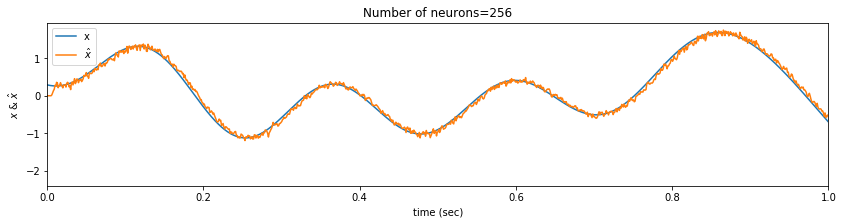

In [29]:
N=np.array([8,16,32,64,128,256])
#N=np.array([8,16])

distortionError=np.zeros(N.size)

for i in range(N.size):
    distortionError[i]=DecodingEnsemble(N[i],T=T,seed=i)

Text(0, 0.5, '$RMSE$')

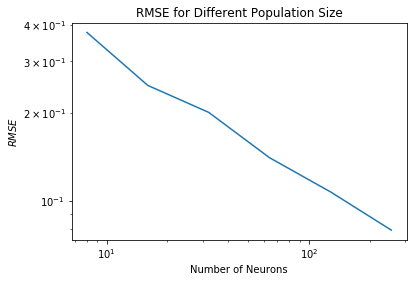

In [30]:
#ploting Error due to Distortion
plt.loglog(N,distortionError,label='RMSE')
plt.title("RMSE for Different Population Size")
plt.xlabel('Number of Neurons')
plt.ylabel('$RMSE$')

## 4) Connecting two groups of neurons

For this question, use two groups of neurons with intercepts between [-1, 1] (i.e. radius = 1) to compute $y = 2x+1$.  The first group of neurons will represent $x$ and the second group will represent $y$.

Start by computing decoders.  You will need two decoders: one to decode $f(x)=2x+1$ from the first population, and one to decode $f(y)=y$ (the standard representational decoder) from the second population.  Remember that $\Upsilon$ can change depending on what function you want to decode.

Use the same neuron parameters as for previous questions (other than the radius), and use 200 randomly generated neurons in each population.

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[1 mark] Show the behaviour of the system with an input of $x(t)=t-1$ for 1 second (a linear ramp from -1 to 0).  Plot the ideal $x(t)$ and $y(t)$ values, along with $\hat{y}(t)$.</li>
<ul>
<li>Note that you should use the decoders that work for any input over the range of intercepts: do not re-compute decoders for any particular input (i.e. set of $x$ values).</li>
<li>Input $x(t)$ into the first group of neurons and produce spikes.  Decode from those spikes using the decoder for $f(x)=2x+1$.  Input that decoded result into the second group of neurons to produce spikes.  Use the second decoder ($f(y)=y$) to decode $\hat{y}(t)$.</li>
<li>Make sure the maximum firing rates are now at -1 or 1 (i.e., the radius is 1).</li>
</ul>
<p>
<li>[0.5 marks] Repeat part (a) with an input that is ten randomly chosen values between -1 and 0, each one held for 0.1 seconds (a randomly varying step input)</li>

<li>[0.5 marks] Repeat part (a) with an input that is $x(t)=0.2sin(6\pi t)$. Briefly discuss the results for this question.</li>
</ol>

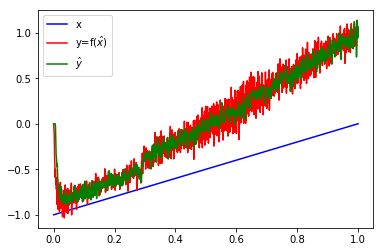

In [31]:
#=======================================
#4.a) Behaviour of the system to x(t)=t-1
#========================================
N_A=200
N_B=200
T=1
dt=0.001
dx=dt
S=int(T/dt)
signal_range=[-1,1]
t=np.linspace(0,T,S)

x=t-1

dimension=1
Alpha,Jbias=CalcAlphaJbias(N_A)
encoder=CalcEncoder(dimension=1,N=N_A) 

neurons_i=spikingNeurons(N_A,dimension,x.copy(),signal_range, dt, Alpha,encoder, Jbias, tau_rc=0.02, tau_ref=0.002)
spikes_i=neurons_i.spikesTrain()

fSpikes_i=np.zeros([N_A,S])

for i in range(N_A): 
    for j in range(t.size):
        t_prime=t-j*dt
        h=PSC_Filter(t_prime,dt,n=0,tau=0.005)
       
        fSpikes_i[i]+=spikes_i[i,j]*h
             
A_i=fSpikes_i

def myFunction(x):
    return 2*x+1

f_x=myFunction(x)

Gamma=np.dot(A_i,A_i.T)*dx
Upsilon=np.dot(A_i,f_x)*dx
d_fx=np.dot(np.linalg.pinv(Gamma),Upsilon)

f_xhat=np.dot(A_i.T,d_fx)
#===========================================
#Computing yhat
#============================================
y=f_xhat

B_j=np.zeros((N_B,y.size))

dimension=1
Alpha,Jbias=CalcAlphaJbias(N_B)
encoder=CalcEncoder(dimension=1,N=N_B) 

neurons_j=spikingNeurons(N_B,dimension,f_xhat.copy(),signal_range, dt, Alpha, Jbias,encoder, tau_rc=0.02, tau_ref=0.002)
spikes_j=neurons_j.spikesTrain()

fSpikes_j=np.zeros([N_B,S])

for i in range(N_B): 
    for j in range(t.size):
        t_prime=t-j*dt
        h=PSC_Filter(t_prime,dt,n=0,tau=0.005)
       
        fSpikes_j[i]+=spikes_j[i,j]*h
             
B_j=fSpikes_j

Gamma=np.dot(B_j,B_j.T)*dx
Upsilon=np.dot(B_j,y)*dx
d_y=np.dot(np.linalg.pinv(Gamma),Upsilon)

yhat=np.dot(B_j.T,d_y)

plt.plot(t,x,'b',label='x')
plt.plot(t,f_xhat,'r',label='y=f($\hat{x})$')
plt.plot(t,yhat,'g',label='$\hat{y}$')
plt.legend()

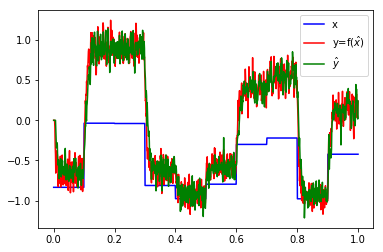

In [33]:
#=================================================
#4.b) Behaviour of the system to piecewise randon
#=================================================
x = np.zeros(int(T/dt))
for i in range(10):
    x[i*100:(i+1)*100]=np.random.uniform(-1,0)

dimension=1    
Alpha,Jbias=CalcAlphaJbias(N_A)
encoder=CalcEncoder(dimension=1,N=N_A) 

neurons_i=spikingNeurons(N_A,dimension,x.copy(),signal_range, dt, Alpha, Jbias,encoder, tau_rc=0.02, tau_ref=0.002)
spikes_i=neurons_i.spikesTrain()

fSpikes_i=np.zeros([N_A,S])

for i in range(N_A): 
    for j in range(t.size):
        t_prime=t-j*dt
        h=PSC_Filter(t_prime,dt,n=0,tau=0.005)
       
        fSpikes_i[i]+=spikes_i[i,j]*h
             
A_i=fSpikes_i

def myFunction(x):
    return 2*x+1

f_x=myFunction(x)

Gamma=np.dot(A_i,A_i.T)*dx
Upsilon=np.dot(A_i,f_x)*dx
d_fx=np.dot(np.linalg.pinv(Gamma),Upsilon)

f_xhat=np.dot(A_i.T,d_fx)
#===========================================
#Computing yhat
#============================================
y=f_xhat

dimension=1
Alpha,Jbias=CalcAlphaJbias(N_B)
encoder=CalcEncoder(dimension=1,N=N_B) 

neurons_j=spikingNeurons(N_B,dimension,f_xhat,signal_range, dt, Alpha, Jbias,encoder, tau_rc=0.02, tau_ref=0.002)
spikes_j=neurons_j.spikesTrain()

fSpikes_j=np.zeros([N_B,S])

for i in range(N_B): 
    for j in range(t.size):
        t_prime=t-j*dt
        h=PSC_Filter(t_prime,dt,n=0,tau=0.005)
       
        fSpikes_j[i]+=spikes_j[i,j]*h
             
B_j=fSpikes_j

Gamma=np.dot(B_j,B_j.T)*dx
Upsilon=np.dot(B_j,y)*dx
d_y=np.dot(np.linalg.pinv(Gamma),Upsilon)

yhat=np.dot(B_j.T,d_y)

plt.plot(t,x,'b',label='x')
plt.plot(t,f_xhat,'r',label='y=f($\hat{x})$')
plt.plot(t,yhat,'g',label='$\hat{y}$')
plt.legend()

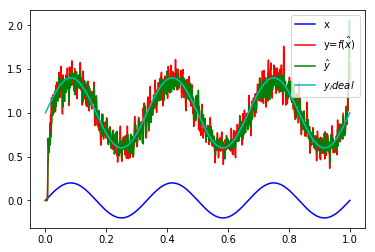

In [23]:
#=================================================
#4.c) Behaviour of the system to periodic signal
#=================================================
x = 0.2*np.sin(6*np.pi*t)
y_ideal=2*x+1

dimension=1
Alpha,Jbias=CalcAlphaJbias(N_A)
encoder=CalcEncoder(dimension=1,N=N_A) 

neurons_i=spikingNeurons(N_A,dimension,x.copy(),signal_range, dt, Alpha, Jbias,encoder, tau_rc=0.02, tau_ref=0.002)
spikes_i=neurons_i.spikesTrain()

fSpikes_i=np.zeros([N_A,S])

for i in range(N_A): 
    for j in range(t.size):
        t_prime=t-j*dt
        h=PSC_Filter(t_prime,dt,n=0,tau=0.005)
       
        fSpikes_i[i]+=spikes_i[i,j]*h
             
A_i=fSpikes_i

def myFunction(x):
    return 2*x+1

f_x=myFunction(x)

Gamma=np.dot(A_i,A_i.T)*dx
Upsilon=np.dot(A_i,f_x)*dx
d_fx=np.dot(np.linalg.pinv(Gamma),Upsilon)

f_xhat=np.dot(A_i.T,d_fx)
#===========================================
#Computing yhat
#============================================
y=f_xhat

dimension=1
Alpha,Jbias=CalcAlphaJbias(N_B)
encoder=CalcEncoder(dimension=1,N=N_B) 

neurons_j=spikingNeurons(N_B,dimension,f_xhat,signal_range, dt, Alpha, Jbias,encoder, tau_rc=0.02, tau_ref=0.002)
spikes_j=neurons_j.spikesTrain()

fSpikes_j=np.zeros([N_B,S])

for i in range(N_B): 
    for j in range(t.size):
        t_prime=t-j*dt
        h=PSC_Filter(t_prime,dt,n=0,tau=0.005)
       
        fSpikes_j[i]+=spikes_j[i,j]*h
             
B_j=fSpikes_j

Gamma=np.dot(B_j,B_j.T)*dx
Upsilon=np.dot(B_j,y)*dx
d_y=np.dot(np.linalg.pinv(Gamma),Upsilon)

yhat=np.dot(B_j.T,d_y)


plt.plot(t,x,'b',label='x')
plt.plot(t,f_xhat,'r',label='y=$\hat{f(x)}$')
plt.plot(t,yhat,'g',label='$\hat{y}$')
plt.plot(t,y_ideal,'c',label='$y_ideal$')
plt.legend()

### Discussion 4.C.
The estimted y function is super noisy and since it uses casual filter it starts from 0. We have used "transformational decoders" for estimating xhat and then "representational decoders" to estimate yhat. We did not consider satuaration in the model of our neurons so even when the amount of output exceeds the radius(xRange) they still reconstruct the input signal. However, we had better to consider neurons satuaration as Nengo.  

## 5) Connecting three groups of neurons

For this question, use three groups of neurons with intercepts from [-1, 1] to compute $z = 2y+0.5x$.  Follow the same steps as question 4, but take the decoded outputs from the first two groups of neurons ($f(y)=2y$ and $f(x)=0.5x$), add them together, and feed that into the third group of neurons.

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[1 mark] Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for an input of $x(t)=cos(3\pi t)$ and $y(t)=0.5 sin (2 \pi t)$ (over 1.0 seconds)</li>

<li>[0.5 marks] Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for a random input over 1 second.  For $x(t)$ use a random signal with a limit of 8 Hz and `rms`=1.  For $y(t)$ use a random signal with a limit of 5 Hz and `rms`=0.5.</li>
</ol>


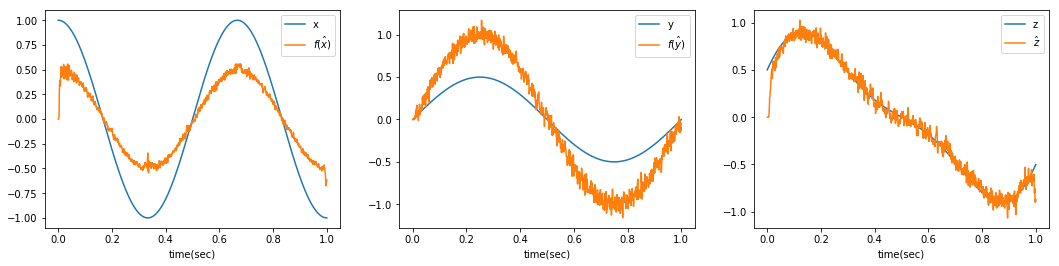

In [24]:
#=======================================================
#a.Computing z=2y+0.5x when x & y are priodic functions
#=======================================================
T=1
dt=0.001
dx=0.001
signal_range=[-1,1]
t=np.linspace(0,T,int(T/dt))

N_A=200
N_B=200
N_C=200

x=np.cos(3*np.pi*t)
y=0.5*np.sin(2*np.pi*t)
z_ideal=2*y+0.5*x

#============================
#Computing f_xhat
#============================
dimension=1
Alpha,Jbias=CalcAlphaJbias(N_A)
encoder=CalcEncoder(dimension=1,N=N_A) 

neurons_i=spikingNeurons(N_A,dimension,x.copy(),signal_range, dt, Alpha, Jbias,encoder, tau_rc=0.02, tau_ref=0.002)
spikes_i=neurons_i.spikesTrain()

fSpikes_i=np.zeros([N_A,t.size])
        
for i in range(N_A): 
    for j in range(t.size):
        t_prime=t-j*dt
        h=PSC_Filter(t_prime,dt,n=0,tau=0.005)
       
        fSpikes_i[i]+=spikes_i[i,j]*h
             
A_i=fSpikes_i

def myFunction(x):
    return 0.5*x

f_x=myFunction(x)

Gamma=np.dot(A_i,A_i.T)*dx
Upsilon=np.dot(A_i,f_x)*dx
d_fx=np.dot(np.linalg.pinv(Gamma),Upsilon)

f_xhat=np.dot(A_i.T,d_fx)

#===========================================
#Computing f_yhat
#===========================================
dimension=1
Alpha,Jbias=CalcAlphaJbias(N_B)
encoder=CalcEncoder(dimension=1,N=N_B) 

neurons_j=spikingNeurons(N_B,dimension,y.copy(),signal_range, dt, Alpha, Jbias,encoder,0.02,0.002)
spikes_j=neurons_j.spikesTrain()

fSpikes_j=np.zeros([N_B,t.size])
        
for i in range(N_B): 
    for j in range(t.size):
        t_prime=t-j*dt
        h=PSC_Filter(t_prime,dt,n=0,tau=0.005)
       
        fSpikes_j[i]+=spikes_j[i,j]*h
             
B_j=fSpikes_j

def myFunction(y):
    return 2*y

f_y=myFunction(y)

Gamma=np.dot(B_j,B_j.T)*dx
Upsilon=np.dot(B_j,f_y)*dx
d_fy=np.dot(np.linalg.pinv(Gamma),Upsilon)

f_yhat=np.dot(B_j.T,d_fy)

#================================
#Computing zhat
#================================
z=f_xhat+f_yhat

dimension=1
Alpha,Jbias=CalcAlphaJbias(N_C)
encoder=CalcEncoder(dimension=1,N=N_C) 

neurons_k=spikingNeurons(N_C,dimension,z.copy(),signal_range, dt, Alpha, Jbias,encoder,0.02,0.002)
spikes_k=neurons_k.spikesTrain()

fSpikes_k=np.zeros([N_C,t.size])
        
for i in range(N_C): 
    for j in range(t.size):
        t_prime=t-j*dt
        h=PSC_Filter(t_prime,dt,n=0,tau=0.005)
       
        fSpikes_k[i]+=spikes_k[i,j]*h
             
C_k=fSpikes_k

Gamma=np.dot(C_k,C_k.T)*dx
Upsilon=np.dot(C_k,z)*dx
d_z=np.dot(np.linalg.pinv(Gamma),Upsilon)

zhat=np.dot(C_k.T,d_z)

#Plotting
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.plot(t,x,label='x')
plt.plot(t,f_xhat,label='$\hat{f(x)}$')
plt.xlabel('time(sec)')
plt.legend()

plt.subplot(1,3,2)
plt.plot(t,y,label='y')
plt.plot(t,f_yhat,label='$\hat{f(y)}$')
plt.xlabel('time(sec)')
plt.legend()

plt.subplot(1,3,3)
plt.plot(t,z_ideal,label='z')
plt.plot(t,zhat,label='$\hat{z}$')
plt.xlabel('time(sec)')
plt.legend()


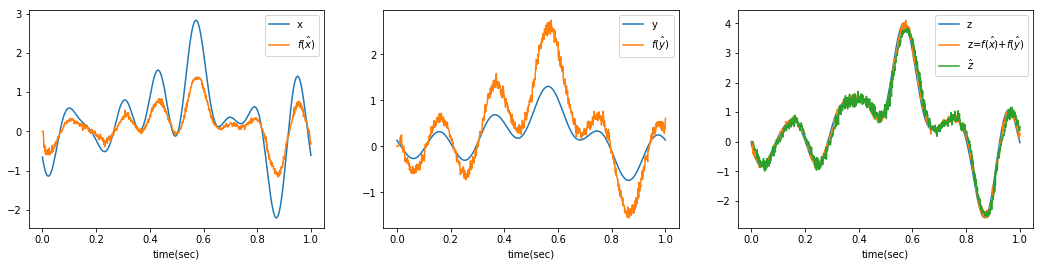

In [25]:
#=======================================================
#a.Computing z=2y+0.5x when x & y are random functions
#=======================================================
T=1
dt=0.001
dx=0.001
signal_range=[-1,1]
t=np.linspace(0,T,int(T/dt))

N_A=200
N_B=200
N_C=200

[x,X]=generate_signal(T,dt,rms=1,limit=8,seed=10)
[y,Y]=generate_signal(T,dt,rms=0.5,limit=5,seed=10)
z_ideal=2*y+0.5*x

#============================
#Computing f_xhat
#============================
dimension=1
Alpha,Jbias=CalcAlphaJbias(N_A)
encoder=CalcEncoder(dimension=1,N=N_A) 

neurons_i=spikingNeurons(N_A,dimension,x.copy(),signal_range, dt, Alpha, Jbias,encoder, tau_rc=0.02, tau_ref=0.002)
spikes_i=neurons_i.spikesTrain()

fSpikes_i=np.zeros([N_A,t.size])
        
for i in range(N_A): 
    for j in range(t.size):
        t_prime=t-j*dt
        h=PSC_Filter(t_prime,dt,n=0,tau=0.005)
       
        fSpikes_i[i]+=spikes_i[i,j]*h
             
A_i=fSpikes_i

def myFunction(x):
    return 0.5*x

f_x=myFunction(x)

Gamma=np.dot(A_i,A_i.T)*dx
Upsilon=np.dot(A_i,f_x)*dx
d_fx=np.dot(np.linalg.pinv(Gamma),Upsilon)

f_xhat=np.dot(A_i.T,d_fx)

#===========================================
#Computing f_yhat
#===========================================
dimension=1
Alpha,Jbias=CalcAlphaJbias(N_B)
encoder=CalcEncoder(dimension=1,N=N_B) 

neurons_j=spikingNeurons(N_B,dimension,y.copy(),signal_range, dt, Alpha, Jbias,encoder,0.02,0.002)
spikes_j=neurons_j.spikesTrain()

fSpikes_j=np.zeros([N_B,t.size])
        
for i in range(N_B): 
    for j in range(t.size):
        t_prime=t-j*dt
        h=PSC_Filter(t_prime,dt,n=0,tau=0.005)
       
        fSpikes_j[i]+=spikes_j[i,j]*h
             
B_j=fSpikes_j

def myFunction(y):
    return 2*y

f_y=myFunction(y)

Gamma=np.dot(B_j,B_j.T)*dx
Upsilon=np.dot(B_j,f_y)*dx
d_fy=np.dot(np.linalg.pinv(Gamma),Upsilon)

f_yhat=np.dot(B_j.T,d_fy)

#================================
#Computing zhat
#================================
z=f_xhat+f_yhat

dimension=1
Alpha,Jbias=CalcAlphaJbias(N_C)
encoder=CalcEncoder(dimension=1,N=N_C) 

neurons_k=spikingNeurons(N_C,dimension,z,signal_range, dt, Alpha, Jbias,encoder,0.02,0.002)
spikes_k=neurons_k.spikesTrain()

fSpikes_k=np.zeros([N_C,t.size])
        
for i in range(N_C): 
    for j in range(t.size):
        t_prime=t-j*dt
        h=PSC_Filter(t_prime,dt,n=0,tau=0.005)
       
        fSpikes_k[i]+=spikes_k[i,j]*h
             
C_k=fSpikes_k

Gamma=np.dot(C_k,C_k.T)*dx
Upsilon=np.dot(C_k,z)*dx
d_z=np.dot(np.linalg.pinv(Gamma),Upsilon)

zhat=np.dot(C_k.T,d_z)

#Plotting
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.plot(t,x,label='x')
plt.plot(t,f_xhat,label='$\hat{f(x)}$')
plt.xlabel('time(sec)')
plt.legend()

plt.subplot(1,3,2)
plt.plot(t,y,label='y')
plt.plot(t,f_yhat,label='$\hat{f(y)}$')
plt.xlabel('time(sec)')
plt.legend()

plt.subplot(1,3,3)
plt.plot(t,z_ideal,label='z')
plt.plot(t,z,label='z=$\hat{f(x)}$+$\hat{f(y)}$')
plt.plot(t,zhat,label='$\hat{z}$')
plt.xlabel('time(sec)')
plt.legend()

## 6) Computing with vectors

Do the same thing as questions 4 and 5, but with 2-dimensional vectors instead of scalars.  Everything else is the same.  For your encoders $e$, randomly generate them over the unit circle.  

The function to compute is $w = x-3y+2z-2q$.  This requires five groups of neurons: $x$, $y$, $z$, $q$, and $w$.  Each of them represents a 2-dimensional value.  The outputs from $x$, $y$, $z$, and $q$ all feed into $w$.

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[1 mark] Plot the decoded output $\hat{w}(t)$ and the ideal $w$ for $x=[0.5,1], y=[0.1,0.3], z=[0.2,0.1], q = [0.4,-0.2]$.  (Note that these are all constants so they don't change over time, but still plot it for 1.0 seconds on one or more 2D graphs)</li>
<li>[0.5 marks] Produce the same plot for $x=[0.5,1], y=[sin(4\pi t),0.3], z=[0.2,0.1], q = [sin(4\pi t),-0.2]$.</li>
<li>[0.5 marks] Describe your results and discuss why and how they stray from the expected answer.</li></ol>

In [26]:
def myFunction(x,transformation):
    return transformation*x # Transformational decoders

In [27]:
def vectorTransformation(N,dimension,x,signal_range,T,dt,transformation):
    
    nS=int(T/dt) #number of sample
    t=np.arange(nS)*dt
    
    Alpha,Jbias=CalcAlphaJbias(N)
    encoder=CalcEncoder(N,dimension) 
    
    neurons=spikingNeurons(N,dimension,x,signal_range, dt, Alpha, Jbias,encoder, tau_rc=0.02, tau_ref=0.002)
    spikes=neurons.spikesTrain()

    fSpikes=np.zeros([N,t.size])

    for i in range(N): 
        for j in range(t.size):
            t_prime=t-j*dt
            h=PSC_Filter(t_prime,dt,n=0,tau=0.005)

            fSpikes[i]+=spikes[i,j]*h

    A=fSpikes

    f_x=myFunction(x,transformation)

    Gamma=np.dot(A,A.T)/nS
    Upsilon_x=np.dot(A,f_x[:,0])/nS
    Upsilon_y=np.dot(A,f_x[:,1])/nS
    d_fx_x=np.dot(np.linalg.pinv(Gamma),Upsilon_x)
    d_fx_y=np.dot(np.linalg.pinv(Gamma),Upsilon_y)
    d_fx=np.array([d_fx_x,d_fx_y])

    f_xhat=np.dot(A.T,d_fx.T)

    return f_xhat

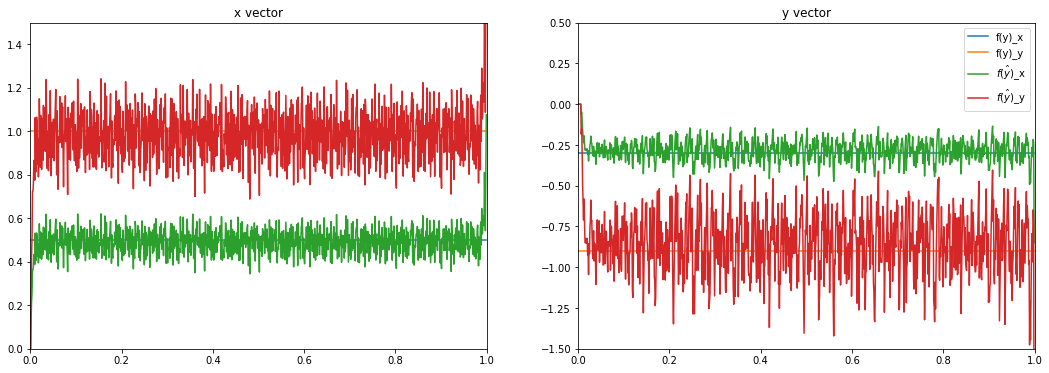

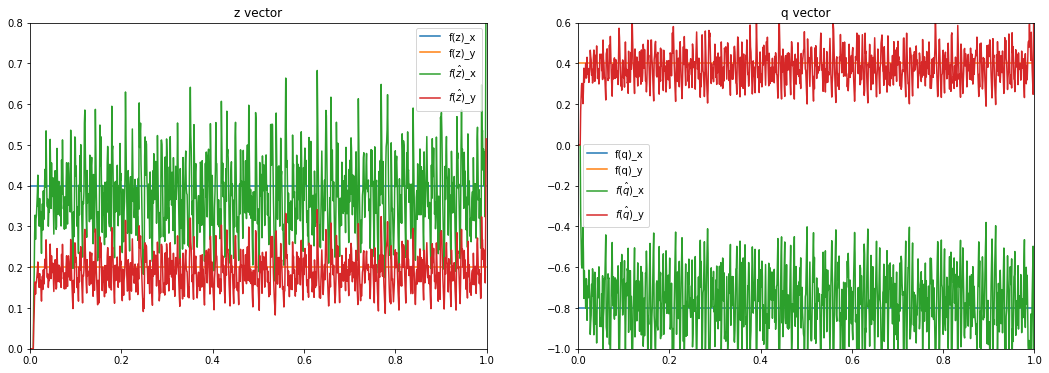

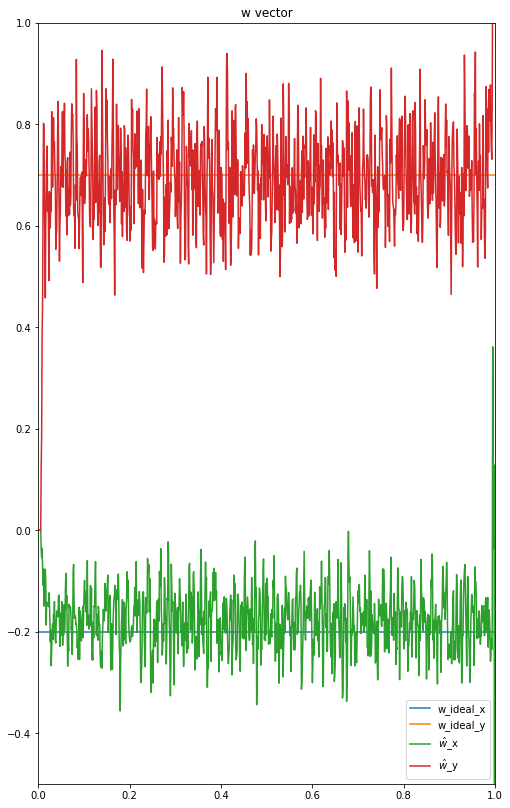

In [28]:
#6.a

T=1
dt=0.001
nS=int(T/dt) #number of sample
t=np.arange(nS)*dt
signal_range=[-1,1]
dimension=2



# #======================
# #f(x)=x calculation
# #======================
N_A=100
x=np.array([0.5*np.ones(nS),1*np.ones(nS)]).T
f_xhat=vectorTransformation(N_A,dimension,x.copy(),signal_range,T,dt,transformation=1)


# #======================
# #f(y)=-3y calculation
# #======================
N_B=100
y=np.array([0.1*np.ones(nS),0.3*np.ones(nS)]).T
f_yhat=vectorTransformation(N_B,dimension,y.copy(),signal_range,T,dt,transformation=-3)

# #======================
# #f(z)=2z calculation
# #======================
N_C=100
z=np.array([0.2*np.ones(nS),0.1*np.ones(nS)]).T
f_zhat=vectorTransformation(N_C,dimension,z.copy(),signal_range,T,dt,transformation=2)

# #======================
# #f(q)=-2q calculation
# #======================
N_D=100
q=np.array([0.4*np.ones(nS),-0.2*np.ones(nS)]).T
f_qhat=vectorTransformation(N_D,dimension,q.copy(),signal_range,T,dt,transformation=-2)

# #======================
# # w calculation
# #======================
N_E=100
w_ideal=x-3*y+2*z-2*q
w=f_xhat+f_yhat+f_zhat+f_qhat
f_what=vectorTransformation(N_E,dimension,w,signal_range,T,dt,transformation=1)


#===========================
#Plotting
#===========================
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(t,x[:,0],label="f(x)_x")
plt.plot(t,x[:,1],label="f(x)_y")
plt.plot(t,f_xhat[:,0],label="$\hat{f(x)}$_x")
plt.plot(t,f_xhat[:,1],label="$\hat{f(x)}$_y")
plt.title('x vector')
plt.xlim(0,1)
plt.ylim(0,1.5)


plt.subplot(1,2,2)
plt.plot(t,-3*y[:,0],label="f(y)_x")
plt.plot(t,-3*y[:,1],label="f(y)_y")
plt.plot(t,f_yhat[:,0],label="$\hat{f(y)}$_x")
plt.plot(t,f_yhat[:,1],label="$\hat{f(y)}$_y")
plt.title('y vector')
plt.xlim(0,1)
plt.ylim(-1.5,0.5)
plt.legend()

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(t,2*z[:,0],label="f(z)_x")
plt.plot(t,2*z[:,1],label="f(z)_y")
plt.plot(t,f_zhat[:,0],label="$\hat{f(z)}$_x")
plt.plot(t,f_zhat[:,1],label="$\hat{f(z)}$_y")
plt.title('z vector')
plt.xlim(0,1)
plt.ylim(0,0.8)
plt.legend()

plt.subplot(1,2,2)
plt.plot(t,-2*q[:,0],label="f(q)_x")
plt.plot(t,-2*q[:,1],label="f(q)_y")
plt.plot(t,f_qhat[:,0],label="$\hat{f(q)}$_x")
plt.plot(t,f_qhat[:,1],label="$\hat{f(q)}$_y")
plt.title('q vector')
plt.xlim(0,1)
plt.ylim(-1,0.6)
plt.legend()

plt.figure(figsize=(18,14))
plt.subplot(1,2,1)
plt.plot(t,w_ideal[:,0],label="w_ideal_x")
plt.plot(t,w_ideal[:,1],label="w_ideal_y")
plt.plot(t,f_what[:,0],label="$\hat{w}$_x")
plt.plot(t,f_what[:,1],label="$\hat{w}$_y")
plt.title('w vector')
plt.xlim(0,1)
plt.ylim(-0.5,1)
plt.legend()

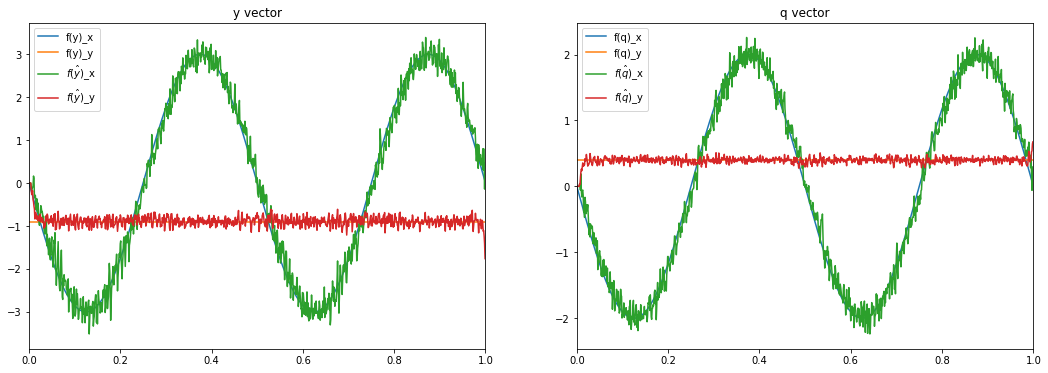

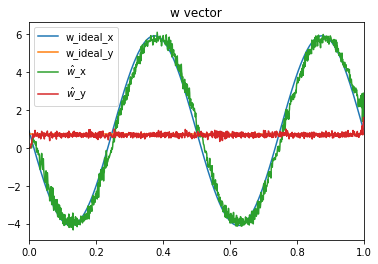

In [29]:
#=============================
#6.b. y and q with periodic part
#=============================

N_B=100
y=np.array([np.sin(4*np.pi*t),0.3*np.ones(nS)]).T
f_yhat=vectorTransformation(N_B,dimension,y.copy(),signal_range,T,dt,transformation=-3)
            
N_D=100
q=np.array([np.sin(4*np.pi*t),-0.2*np.ones(nS)]).T
f_qhat=vectorTransformation(N_D,dimension,q.copy(),signal_range,T,dt,transformation=-2)
            
# #======================
# # w calculation
# #======================
N_E=100
w_ideal=x-3*y+2*z-2*q
w=f_xhat+f_yhat+f_zhat+f_qhat
f_what=vectorTransformation(N_E,dimension,w,signal_range,T,dt,transformation=1)


#===========================
#Plotting
#===========================
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(t,-3*y[:,0],label="f(y)_x")
plt.plot(t,-3*y[:,1],label="f(y)_y")
plt.plot(t,f_yhat[:,0],label="$\hat{f(y)}$_x")
plt.plot(t,f_yhat[:,1],label="$\hat{f(y)}$_y")
plt.title('y vector')
plt.xlim(0,1)
#plt.ylim(-1.5,0.5)
plt.legend()

plt.subplot(1,2,2)
plt.plot(t,-2*q[:,0],label="f(q)_x")
plt.plot(t,-2*q[:,1],label="f(q)_y")
plt.plot(t,f_qhat[:,0],label="$\hat{f(q)}$_x")
plt.plot(t,f_qhat[:,1],label="$\hat{f(q)}$_y")
plt.title('q vector')
plt.xlim(0,1)
#plt.ylim(-1,0.6)
plt.legend()

plt.figure()
plt.plot(t,w_ideal[:,0],label="w_ideal_x")
plt.plot(t,w_ideal[:,1],label="w_ideal_y")
plt.plot(t,f_what[:,0],label="$\hat{w}$_x")
plt.plot(t,f_what[:,1],label="$\hat{w}$_y")
plt.title('w vector')
plt.xlim(0,1)
#plt.ylim(-0.5,1)
plt.legend()

### Answer to 6.C
The same as the previous question the output results of this section are too noisy. No saturation effect has been considered in my simulation so the decoded results still follow the input even when they pass the xRange limits=[-1,1]. In addition there is a delay between the ideal sin wave and simulated one. 